# Figure S2

In [1]:
## Basics
import numpy as np
import pandas as pd
import glob

## Local functions
import sys
sys.path.append("../code/scripts")
import parseaf as paf
import composition as comp
import mdtraj as md

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499',
          'null':"black"}

In [2]:
# Filepaths
#path_to_af_data = "/Volumes/DATA/alphafold/UP000002311_559292_YEAST/"
path_to_af_data = '/Users/rosalindpan/drummondlab/hcrpaper_data/UP000002311_559292_YEAST_v2/'

In [3]:
def get_ss_freqs(seq, counts = False, sort_output = True, gaps = False):
    ss_types = ['C', 'E', 'H']
    
    all_seq_ss = []
    all_seq_freqs = []
    
    # Parse sequence
    seq = list(seq)
    seq_ss, seq_counts = np.unique(seq, return_counts=True)
    zero_freq_ss = np.setxor1d(ss_types, seq_ss)

    seq_ss = np.append(seq_ss, zero_freq_ss)
    seq_freqs = np.append(seq_counts, np.zeros(zero_freq_ss.size))
    if not counts:
        seq_freqs = seq_freqs / len(seq)

    if sort_output:
        seq_freqs_sorted = seq_freqs[seq_ss.argsort()]
        all_seq_freqs.append(seq_freqs_sorted)

    else:
        all_seq_ss.append(seq_ss)
        all_seq_freqs.append(seq_freqs)
    
    if sort_output:
        return(all_seq_freqs)
    else:
        return(all_seq_ss, all_seq_freqs)
    
    
def subcategorybar(X, vals, labs, width=0.8, colors=None):
    n = len(vals)
    _X = np.arange(len(X))
    if colors:
        for i in range(n):
            plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                    width=width/float(n), align="edge", label=labs[i], color=colors[i])
    else:
        for i in range(n):
            plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                    width=width/float(n), align="edge", label=labs[i])
    plt.xticks(_X, X)
    plt.legend()

In [4]:
# Load data
# These data are generated in the associated Figure 2 notebook
hits_disordered_frac = np.loadtxt("../data/af_ss_processed/hits_trimmed_disordered_frac.txt")
rand_disordered_frac = np.loadtxt("../data/af_ss_processed/rand_trimmed_disordered_frac.txt")
idr_disordered_frac = np.loadtxt("../data/af_ss_processed/idr_disordered_frac.txt")

hits_conf = np.load("../data/af_ss_processed/hits_trimmed_conf.npy", allow_pickle=True)
rand_conf = np.load("../data/af_ss_processed/rand_trimmed_conf.npy", allow_pickle=True)
idr_conf = np.load("../data/af_ss_processed/idr_conf.npy", allow_pickle=True)

hits_ss = np.load("../data/af_ss_processed/hits_trimmed_ss.npy", allow_pickle=True)
rand_ss = np.load("../data/af_ss_processed/rand_trimmed_ss.npy", allow_pickle=True)
idr_ss = np.load("../data/af_ss_processed/idr_ss.npy", allow_pickle=True)

In [5]:
hits_conf_ss = []
for i in np.arange(len(hits_ss)):
    try:
        hits_conf_ss.append(hits_ss[i][hits_conf[i]])
    except IndexError:
        print(i)
        continue
hits_conf_ss=np.concatenate(hits_conf_ss).ravel().tolist()

rand_conf_ss = []
for i in np.arange(len(rand_ss)):
    try:
        rand_conf_ss.append(rand_ss[i][rand_conf[i]])
    except IndexError:
        print(i)
        continue
rand_conf_ss=np.concatenate(rand_ss).ravel().tolist()

idr_conf_ss = []
for i in np.arange(len(idr_ss)):
    try:
        idr_conf_ss.append(idr_ss[i][idr_conf[i]])
    except IndexError:
        print(i)
        continue
idr_conf_ss=np.concatenate(idr_ss).ravel().tolist()

In [6]:
# Proportion of total residues that are confidentally predicted
len(hits_conf_ss) / len(np.concatenate(hits_ss))

0.4504187486804138

## A

In [7]:
data_dict = {"Highly charged\nregions":None, "Random\nregions":None, "DisProt\nregions":None}
labs = ["Highly charged\nregions", "Random\nregions", "DisProt\nregions"]
datums = [get_ss_freqs(hits_conf_ss)[0], get_ss_freqs(rand_conf_ss)[0], get_ss_freqs(idr_conf_ss)[0]]

for i in range(3):
    out = {}
    out['Coil'] = datums[i][0]
    out['Sheet'] = datums[i][1]
    out['Helix'] = datums[i][2]
    data_dict[labs[i]] = out

In [8]:
allssdf_prop = pd.DataFrame(data_dict)
allssdf_prop.reset_index(inplace=True)
allssdf_prop.rename(columns={'index':"ss_type"}, inplace=True)
allssdf_prop = allssdf_prop.melt(id_vars='ss_type', var_name="prot_type", value_name='n_aas')

In [9]:
allssdf_prop

,ss_type,prot_type,n_aas
0,Coil,Highly charged\nregions,0.145234
1,Sheet,Highly charged\nregions,0.032695
2,Helix,Highly charged\nregions,0.822070
3,Coil,Random\nregions,0.429194
4,Sheet,Random\nregions,0.130967
5,Helix,Random\nregions,0.439840
6,Coil,DisProt\nregions,0.737920
7,Sheet,DisProt\nregions,0.040240
8,Helix,DisProt\nregions,0.221840


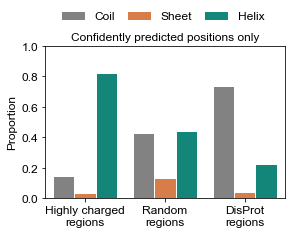

In [10]:
plt.figure(figsize=(4.3,2.8))
sns.barplot(data=allssdf_prop, x="prot_type", y="n_aas", hue='ss_type',
            palette=[cscheme['dis'], cscheme['sheet'], cscheme['helix']],
            edgecolor="white")
plt.xlabel(None)
plt.ylabel("Proportion")
plt.title('Confidently predicted positions only', fontsize=12)
plt.legend(title=None, ncol=3, bbox_to_anchor=(0.96, 1.3), frameon=False,
           columnspacing=1)
plt.ylim(0,1)

plt.savefig('./plots/FigureS2A.png', dpi=300, bbox_inches='tight')
plt.show()

## S2B

In [11]:
df = pd.read_csv('../data/charged_regions/cr_trimmed_raw.csv',
                comment="#")

In [12]:
# Add new columns: secondary structure, confidence, and fraction disordered

def ss_columns(row):
    orf = row['orf']
    uid = row['uni_id']
    seq = row['region.seq']
    
    af_fp = path_to_af_data + 'AF-' + str(uid) + '-F1-model_v2.pdb.gz'
    try:
        pLDDTs = paf.read_bfactor_from_pdb(af_fp)[row['left.bound']:row['right.bound']+1]
    except FileNotFoundError:
        print(af_fp)
        out = np.empty(4)
        out[:] = np.NaN
        return pd.Series(out)
    
    # Get confidence scores mask
    conf = [True if i > 70. else False for i in pLDDTs]
    
    # Get DSSP predictions
    structure = md.load(af_fp)
    ss = md.compute_dssp(structure, simplified=True)
    region_ss = ss[0][row['left.bound']:row['right.bound']+1]
    
    # Score disorder/order
    region_ss_dis = []
    for r, resid in enumerate(region_ss):
        if conf[r]:
            if resid == "C":
                region_ss_dis.append("D")
            else:
                region_ss_dis.append(resid)
        elif pLDDTs[r] < 50.:
            region_ss_dis.append("D")
        else:
            region_ss_dis.append(np.NaN)
    
    return(pd.Series([pLDDTs, conf, region_ss, region_ss_dis]))

In [13]:
newcols = df.apply(ss_columns, axis=1)
newcols.columns = ["pLDDTs", "Confidence_mask", "DSSP_ss", "Scored_ss"]

newdf = df.join(newcols)

/Users/rosalindpan/opt/anaconda3/envs/env_hcr/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


/Users/rosalindpan/drummondlab/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-P53288-F1-model_v2.pdb.gz
/Users/rosalindpan/drummondlab/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-P38811-F1-model_v2.pdb.gz
/Users/rosalindpan/drummondlab/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-P38811-F1-model_v2.pdb.gz
/Users/rosalindpan/drummondlab/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-P36022-F1-model_v2.pdb.gz
/Users/rosalindpan/drummondlab/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-Q12019-F1-model_v2.pdb.gz
/Users/rosalindpan/drummondlab/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-Q12019-F1-model_v2.pdb.gz
/Users/rosalindpan/drummondlab/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-Q12019-F1-model_v2.pdb.gz
/Users/rosalindpan/drummondlab/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-Q12019-F1-model_v2.pdb.gz
/Users/rosalindpan/drummondlab/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-Q6B0X1-F1-model_v2.pdb.gz
/Users/rosalindpan/drummondlab/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-Q08428

In [14]:
def get_p_helix(row):
    scored_ss = row["Scored_ss"]
    try:
        p_helix = ''.join([x for x in scored_ss if x == x]).count("H") / len(scored_ss)
    except TypeError:
        return(np.NaN)
    return(p_helix)


newdf["p_helix"] = newdf.apply(get_p_helix, axis=1)

In [15]:
df_struct_labels = pd.read_csv("../data/charged_regions/cr_trimmed_filtered_aflabel.csv")
df_struct_labels = pd.merge(df_struct_labels, newdf[["orf", "p_helix", "left.bound"]],\
                            how='left', left_on=["orf", "left.bound"], right_on=['orf', 'left.bound'])

In [16]:
df_struct_labels

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,uni_id,orf_label,kappa,label,p_helix
0,YAL011W,SWC3,626,5,53,RTRSKESSIEQKPASRTRTRSRRGKRGRDDDDDDDDEESDDAYDEVGND,49,0.017593,0.591837,P31376,verified,0.539053,disordered,0.000000
1,YAL011W,SWC3,626,169,261,RLFILKNDKIEQKWQDEQELKKKEKELKRKNDAEAKRLRMEERKRQ...,93,0.052936,0.559140,P31376,verified,0.098538,helix,0.795699
2,YAL011W,SWC3,626,361,424,KTAATEPEPKKADDENAEKQQSKEAKTTAESTQVDVKKEEEDVKEK...,64,0.007812,0.500000,P31376,verified,0.089231,disordered,0.000000
3,YAL013W,DEP1,406,84,159,ESLKRPHEDEKEAIDEAKKMKVPGENEDESKEEEKSQELEEAIDSK...,76,0.138444,0.592105,P31385,verified,0.219047,disordered,0.000000
4,YAL019W,FUN30,1132,463,538,ERETKRIRNTTKPKVVEDEDDDVDLEAIDDELPQSEHEDDDYEEED...,76,0.269474,0.644737,P31380,verified,0.498598,disordered,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,YPR148C,YPR148C,436,315,379,DETPSTEDEKPKSEGAEEESKKEANEPTVDDVADRKEDLKSNKVND...,65,0.109402,0.553846,Q06523,verified,0.133727,disordered,0.200000
677,YPR169W,JIP5,493,439,490,KEELLDELDKDLKEDHQEEKESNSKSVKKRKIMKENNKKKDLYEHG...,52,0.000583,0.596154,Q06214,verified,0.199050,disordered,0.115385
678,YPR179C,HDA3,656,513,573,ETLSKLKDAFVKTDNVQDEIEKEERVSVSRDTEKKYMEQEIKRAVD...,61,0.008197,0.508197,Q06623,verified,0.096199,helix,0.918033
679,YPR186C,PZF1,430,373,409,RTFKTKEKYEKHIDKHKVHELKLKILQEKEENKTLVD,37,0.044226,0.513514,P39933,verified,0.050618,helix,0.702703


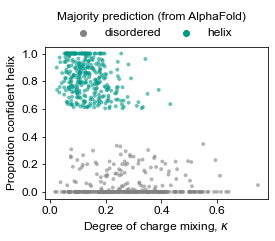

In [17]:
plt.figure(figsize=(4, 2.8))
sns.scatterplot(x = "kappa", y = "p_helix", hue="label", data=df_struct_labels,
                palette=[cscheme["dis"], cscheme["helix"]], s=15, edgecolors=None, linewidth=0, alpha=0.6)
plt.xlabel("Degree of charge mixing, $\kappa$")
plt.ylabel("Proprotion confident helix")
plt.legend(title="Majority prediction (from AlphaFold)",
           bbox_to_anchor=(0.95, 1.3), ncol=2, frameon=False, columnspacing=1)
plt.savefig('./plots/FigureS2B.png', dpi=300, bbox_inches='tight')
plt.show()

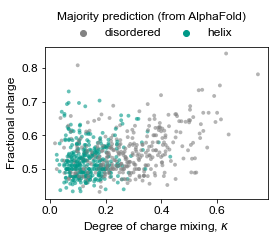

In [19]:
plt.figure(figsize=(4, 2.8))
sns.scatterplot(x = "kappa", y = "frac.charge", hue="label", data=df_struct_labels,
                palette=[cscheme["dis"], cscheme["helix"]], s=15, edgecolors=None, linewidth=0, alpha=0.6)
plt.xlabel("Degree of charge mixing, $\kappa$")
plt.ylabel("Fractional charge")
plt.legend(title="Majority prediction (from AlphaFold)",
           bbox_to_anchor=(0.95, 1.3), ncol=2, frameon=False, columnspacing=1)
plt.savefig('./plots/FigureS2B-alt.png', dpi=300, bbox_inches='tight')
plt.show()